# COMP47590: Advanced Machine Learning
# Assignment 1: Building Heterogenous Ensembles

- Student 1 Name: Finola Cahill
- Student 1 Number: 07645074

## Import Packages

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LinearRegression as LR
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted, check_random_state
from sklearn.utils.multiclass import unique_labels
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import linear_model
from sklearn import neighbors
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.base import is_classifier
from sklearn.utils import resample
from sklearn.base import clone
from sklearn.datasets import load_iris
import itertools
from itertools import chain, combinations
import random
from copy import copy
from scipy import stats
from collections import Counter


## Task 1: The Heterogenous Ensemble Classifier

### Define HeterogenousEnsembleClassifier

In [2]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class HeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Wheter or not to use bootstrap sampling when training base estimators
    
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.


    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = HeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, random_state=None, verbosity = 0):

        """Setup a SuperLearner classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling when training base estimators
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.verbosity = verbosity
        self.validate_parameters()
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has three levels, from 0-2")
        if self.hp_range_map is None:
            self.hp_range_map = {}          

    # The fit function to train a classifier
    def fit(self, X, y):
                
        def checkBootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
                
        def checkValue(value):
            if type(value) is np.ndarray:
                value = value.tolist()
            elif type(value) is not list:
                value = [value]
            return value + [None]
        
        def generate_param_combinations():
            params = []
            for key, value in self.hp_range_map.items():
                params.append(checkValue(value))
                self.keys.append(key)
            product = itertools.product(*params)
            self.params = [ [ p for p in params ] for params in product ] 
        
        def extract_params(n):
            params = {}
            for i,key in enumerate(self.keys):
                if self.params[n][i] is not None:
                    params[key] = self.params[n][i]
            return params
    
        def fit_models(X, y):
            for i in range(0, self.n_estimators):
                X_train, y_train = checkBootstrap(X, y)
                params = extract_params(random.randint(0, (len(self.params)-1)))
                clf = copy(self.base_estimator).set_params(**params)
                self.models.append(clf.fit(X_train, y_train))
        
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        random.seed(self.random_state)
        
        self.params, self.keys, self.models = [], [], []
        
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)
        
        generate_param_combinations()
        
        fit_models(X,y)
    
        return self

#     # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        check_is_fitted(self, ['models'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])

        results = stats.mode(self.ensemble_predictions_)[0]

        return results[0]

    #     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        check_is_fitted(self, ['models'])
        
        X = check_array(X)
        
        probability = []
    
        self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
        
        for p in self.ensemble_predictions_.transpose():
            key, val = np.unique(p, return_counts=True)
            counts = dict(zip(key, val))
            probability.append([(counts[c] / len(p)) if c in counts else 0.0 for c in self.classes_])
        
        return np.array(probability)

### Test the HeterogenousEnsembleClassifier

In [3]:
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
iris = load_iris()
clf = HeterogenousEnsembleClassifier(n_estimators=3)
clf.fit(iris.data, iris.target)
# clf.predict(iris.data)
# clf.predict_proba(iris.data)
# print(x.shape)

HeterogenousEnsembleClassifier(hp_range_map={}, n_estimators=3)

Perform a simple test using the HeterogenousEnsembleClassifier on the Iris dataset

In [4]:
iris = load_iris()
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 10), "gamma":[0.1, 0.5], "probability":[True]}
n_estimators = 10
clf = HeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, verbosity = 1)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)
y_pred2 = clf.predict(iris.data)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.98      0.97        50
           2       0.98      0.96      0.97        50

    accuracy                           0.98       150
   macro avg       0.98      0.98      0.98       150
weighted avg       0.98      0.98      0.98       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,49,1,50
2,0,2,48,50
All,50,51,49,150


Perform a cross validation experiment

In [5]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         1.         1.         0.8
 0.93333333 1.         1.         1.        ]
0.9666666666666668  +/-  0.06146362971528591


## Task 2: The StackedHeterogenousEnsembleClassifier Class

### Define StackedHeterogenousEnsembleClassifier Class

In [6]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class StackedHeterogenousEnsembleClassifier(BaseEstimator, ClassifierMixin):
    
    """An ensemble classifier that uses heterogeneous models at the base layer. Base models are different due to different hyper-parameters used. Aggrefgattion is perfomred using a stack layer model.

    Parameters
    ----------
    base_estimator: scikit-learn estimator 
        The model type to be used at the base layer of the ensemble model.

    hp_range_map: dictionary
        A dictinary of hyperparamters and the ranges of values that will be used from them
        
    n_estimators: int
        How many models to use in the ensemble
        
    bootstrap: boolean
        Whether or not to use bootstrap sampling wehn training base estimators
    
    stack_layer_estimator: scikit-learn estimator 
        Estimator type of the stack  layer model
        
    base_stack_data_ratio: float
        The ratio with which to split the data for straing the base and stack layers.
        
    Attributes
    ----------
    classes_ : array of shape = [n_classes] 
        The classes labels.

    Notes
    -----
    The default values for most base learners are used, unless hyperparameter ranges are specified

    See also
    --------
    

    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.model_selection import cross_val_score
    >>> clf = StackedHeterogenousEnsembleClassifier(tree.DecisionTreeClassifier(), {'max_depth':[5, 10, 15], })
    >>> iris = load_iris()
    >>> cross_val_score(clf, iris.data, iris.target, cv=10)

    """
    # Constructor for the classifier object
    def __init__(self, base_estimator = svm.SVC(), n_estimators = 10, hp_range_map = None, bootstrap = True, stack_layer_estimator = svm.SVC(), base_stack_data_ratio = 0.7, random_state=None, verbosity = 0):

        """Setup a StackedHeterogenousEnsembleClassifier classifier .
        Parameters
        ----------
        base_estimator: The model type to be used at the base layer of the ensemble model.
        hp_range_map: A dictinary of hyperparamters and the ranges of values that will be used from them
        n_estimators: How many models to use in the ensemble
        bootstrap: Wheter or not to use bootstrap sampling wehn training base estimators
        stack_layer_estimator: Estimator type of the stack  layer model
        base_stack_data_ratio: The ratio with which to split the data for straing the base and stack layers.
        
        Returns
        -------
        The estimator
        """     

        # Initialise ranomd state if set
        self.random_state = random_state
        
        # Initialise class variabels
        self.base_estimator = base_estimator
        self.hp_range_map = hp_range_map
        self.n_estimators = n_estimators
        self.bootstrap = bootstrap
        self.stack_layer_estimator = stack_layer_estimator
        self.base_stack_data_ratio = base_stack_data_ratio
        self.verbosity = verbosity
        self.validate_parameters()
        
    
    def validate_parameters(self):
        if self.n_estimators < 1:
             raise ValueError("n_estimators must be >= 1")
        if is_classifier(self.base_estimator) is False:
            raise ValueError("base_estimator must be a classifier")
        if is_classifier(self.stack_layer_estimator) is False:
            raise ValueError("stack_layer_estimator must be a classifier")
        if self.verbosity not in range(0,3):
            raise ValueError("verbosity has range 0-2")
        if self.base_stack_data_ratio <= 0 or self.base_stack_data_ratio >= 1:
            raise ValueError("base_stack_data_ratio must be greater than 0 and smaler than 1.")
        if self.hp_range_map is None:
            self.hp_range_map = {}

    # The fit function to train a classifier
    def fit(self, X, y):

        def checkBootstrap(X, y):
            if self.bootstrap is True:
                return resample(X,y, replace=True)
            return X,y 
        
        def checkValue(value):
            if type(value) is np.ndarray:
                value = value.tolist()
            elif type(value) is not list:
                value = [value]
            return value + [None]
    
        def generate_param_combinations():
            params = []
            for key, value in self.hp_range_map.items():
                params.append(checkValue(value))
                self.keys.append(key)
            product = itertools.product(*params)
            self.params = [ [ p for p in params ] for params in product ] 
        
        def extract_params(n):
            params = {}
            for i,key in enumerate(self.keys):
                if self.params[n][i] is not None:
                    params[key] = self.params[n][i]
            return params
    
        def fit_models(X_train, X_valid, y_train):
            for i in range(0, self.n_estimators):
                X_train, y_train = checkBootstrap(X_train, y_train)
                params = extract_params(random.randint(0, (len(self.params)-1)))
                clf = copy(self.base_estimator).set_params(**params)
                clf.fit(X_train, y_train)
                self.models.append(clf)
                self.model_output.append(clf.predict(X_valid))
        
    
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=self.base_stack_data_ratio,
                                                              random_state=self.random_state)

        random.seed(self.random_state)
        
        self.params, self.keys, self.models, self.model_output = [], [], [], []
                
       #  Count the number of occurrences of each class in the target vector (uses mupy unique function that returns a list of unique values and their counts)
        self.classes_ = np.unique(y)
        
        generate_param_combinations()
        
        fit_models(X_train, X_valid, y_train)
        
        self.stack_layer_estimator.fit(np.array(self.model_output).transpose(), y_valid)
        
        return self
        

#     # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        check_is_fitted(self, ['models'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        ensemble_predictions = np.array([model.predict(X) for model in self.models])
                
        return(self.stack_layer_estimator.predict(ensemble_predictions.transpose()))

    
#     # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):

        check_is_fitted(self, ['models'])
        
        # Check that the input features match the type and shape of the training features
        X = check_array(X)
    
        
        self.ensemble_predictions_ = np.array([model.predict(X) for model in self.models])
                
        return(self.stack_layer_estimator.predict_proba(self.ensemble_predictions_.transpose()))
        

In [7]:
iris = load_iris()
n_estimators = 10
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
# hyperparam_range = None
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 1)
clf.fit(iris.data, iris.target)
clf.predict(iris.data)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Test the StackedHeterogenousEnsembleClassifier

In [8]:
clf.predict_proba(iris.data)

array([[0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.94636   , 0.03252242, 0.02111758],
       [0.

Perform a simple test using the StackedHeterogenousEnsembleClassifier on the Iris dataset

In [9]:
iris = load_iris()
n_estimators = 10
base_estimator = svm.SVC()
hyperparam_range = {"kernel":["rbf", "linear"], "C":np.arange(0.1, 1.0, 0.1), "gamma":[0.1, 0.5], "probability":[True]}
clf = StackedHeterogenousEnsembleClassifier(base_estimator, n_estimators, hyperparam_range, True, svm.SVC(probability=True), 0.7, verbosity = 1)
clf.fit(iris.data, iris.target)
y_pred = clf.predict(iris.data)
print(metrics.classification_report(iris.target, y_pred))
print("Confusion Matrix")
display(pd.crosstab(np.array(iris.target), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))
y_pred = clf.predict_proba(iris.data)
y_pred[0:10]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.90      0.93        50
           2       0.91      0.96      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150

Confusion Matrix


Predicted,0,1,2,All
True,,,,
0,50,0,0,50
1,0,45,5,50
2,0,2,48,50
All,50,47,53,150


array([[0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051],
       [0.94843104, 0.02504845, 0.02652051]])

Perform a cross validation experiment

In [10]:
scores = cross_val_score(clf, iris.data, iris.target, cv=10)
print(scores)
print(np.mean(scores), " +/- ", np.std(scores))

[1.         0.93333333 1.         0.93333333 1.         0.93333333
 0.93333333 1.         1.         1.        ]
0.9733333333333334  +/-  0.03265986323710904


## Task 3: Compare the Performance of the Different Ensembles Defined

### Load Experiment Dataset

Take only a sample of the dataset for fast testing

In [11]:
data_sampling_rate = 0.1

Load the dataset and explore it.

In [12]:
dataset = pd.read_csv('Sensorless_drive_diagnosis.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
display(dataset.head())

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F40,F41,F42,F43,F44,F45,F46,F47,F48,label
24236,-0.000018,-0.000065,0.000022,-0.000005,-0.000016,0.000137,0.009006,0.009071,0.009049,0.010139,...,-0.71995,0.32972,3.0549,-1.4998,-1.4998,-1.4994,-1.5025,-1.5026,-1.5022,5
8804,-0.000016,-0.000018,0.000025,0.000006,0.000070,0.000472,-0.033589,-0.033571,-0.033597,-0.032846,...,-0.70310,1.31590,6.5608,-1.4975,-1.4975,-1.4972,-1.4992,-1.4993,-1.4990,2
7015,0.000005,-0.000014,-0.000105,-0.000009,0.000023,-0.000047,-0.022606,-0.022592,-0.022487,-0.023786,...,-0.79886,14.39700,8.0326,-1.5010,-1.5009,-1.5008,-1.4966,-1.4966,-1.4965,2
29938,0.000017,0.000038,-0.000066,0.000002,0.000022,0.000052,0.008559,0.008521,0.008587,-0.033549,...,-0.69841,1.18870,2.2612,-1.5042,-1.5044,-1.5039,-1.4979,-1.4980,-1.4979,6
35362,0.000020,0.000068,0.000330,-0.000002,0.000017,-0.000290,0.030500,0.030431,0.030101,0.083965,...,-0.67236,-0.38749,4.2663,-1.4990,-1.4989,-1.4982,-1.4910,-1.4910,-1.4906,7


In [13]:
print("Missing Values")
print(sum(dataset.isnull().sum()))

Missing Values
0


In [14]:
y = dataset.pop('label')
X = dataset
y.value_counts()

3     579
11    548
4     548
9     544
6     542
2     542
7     538
1     530
5     515
10    483
8     482
Name: label, dtype: int64

In [15]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, y, \
                       shuffle=True, \
                       stratify = y, \
                       train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, y_train_plus_valid, \
                        shuffle=True, \
                        stratify = y_train_plus_valid, \
                        train_size = 0.5/0.7)

In [16]:
# Make the min max scalar object
min_max_scaler = preprocessing.MinMaxScaler((-1,1))
min_max_scaler.fit(X_train)

# Train the scalar on the training dataset
a = min_max_scaler.transform(X_train)

# Little trick to stop transform from pandas daataframe to numpy array losing column namesWatch out for putting back in columns here
cols = X_train.columns
X_train = pd.DataFrame(a, columns = cols) 

# Also normalise other partitions
a = min_max_scaler.transform(X_train_plus_valid)
X_train_plus_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_valid)
X_valid = pd.DataFrame(a, columns = cols) 
a = min_max_scaler.transform(X_test)
X_test = pd.DataFrame(a, columns = cols) 


In [45]:
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import plot_precision_recall_curve

In [36]:
models = {}
models['DTree'] = DecisionTreeClassifier(random_state=0)
models['kNN'] = KNeighborsClassifier()  
models['SVM'] = svm.SVC(random_state=0)
models['LR'] = LogisticRegression(random_state=0)


In [37]:
##11 hyper parameters each 

In [38]:
hparams = {}
hparams['DTree'] = {'max_depth': list(range(2,100)), 'min_samples_split': list(range(2,50))}
hparams['kNN'] = {'n_neighbors': list(range(3,50)), 'metric': ['euclidean', 'chebyshev', 'minkowski', 'manhattan']}
hparams['SVM'] = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'gamma': np.arange(0.1, 10, .1).tolist()}
hparams['LR'] = {'C': np.arange(1.0, 10.0, 0.5).tolist(), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

In [39]:
from sklearn.metrics import recall_score
def evaluate_model(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='macro')
    return [accuracy, f1, recall]



In [40]:
model_results = pd.DataFrame(columns=['Classifier', 'N_estimators','Accuracy', 'F1', 'Recall'])
i = 0
for m in models:
    clf = copy(models[m])
    y_pred = clf.fit(X_train, y_train).predict(X_valid)
    model_results.loc[i] = [m + ' Single', 0] + evaluate_model(y_pred, y_valid)
    i += 1
    for n in [5, 10, 20, 50]:
        clf = HeterogenousEnsembleClassifier(base_estimator=models[m], hp_range_map=hparams[m], n_estimators=n, random_state=1)
        y_pred = clf.fit(X_train, y_train).predict(X_valid)
        model_results.loc[i] = [m, n] + evaluate_model(y_pred, y_valid)
        i += 1

/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_res

/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/finolacahill/opt/anaconda3/lib/python3.8/site-pac

In [41]:
def plot_subplot(fig, ax, i, feature,title, res):
    X = np.arange(1)
    ax.axhline(y=res.iloc[i][feature], color='red')
    ax.bar(X + 0.00, res.iloc[i][feature], color = 'b', width = 0.05, label="N=1")
    ax.bar(X + 0.1,  res.iloc[i+1][feature], color = 'g', width = 0.05, label = "N=5")
    ax.bar(X + 0.20, res.iloc[i+2][feature], color = 'r', width = 0.05, label = "N=10")
    ax.bar(X + 0.30, res.iloc[i+3][feature], color = 'y', width = 0.05, label = "N=20")
    ax.bar(X + 0.40, res.iloc[i+4][feature], color = 'k', width = 0.05, label = "N=50")
    ax.set_title(title)

def plot_xsection(results, feature, title):
    f, axs = plt.subplots(2, 2, figsize=(14,12), sharex=True)
    plot_subplot(f, axs[0,0], 0, feature, "Decision Tree", results)
    plot_subplot(f, axs[0,1], 5, feature,"kNN", results)
    plot_subplot(f, axs[1,0], 10, feature,"SVM", results)
    plot_subplot(f, axs[1,1], 15, feature,"Logistic Regression", results)
    b = mpatches.Patch(color='blue', label='N=1')
    g = mpatches.Patch(color='green', label='N=5')
    r = mpatches.Patch(color='red', label='N=10')
    ye = mpatches.Patch(color='yellow', label='N=20')
    k = mpatches.Patch(color='black', label='N=50')
    plt.legend(handles=[b, g, r, ye, k], bbox_to_anchor=(1.05, 1), loc='upper left')
    f.suptitle(title)

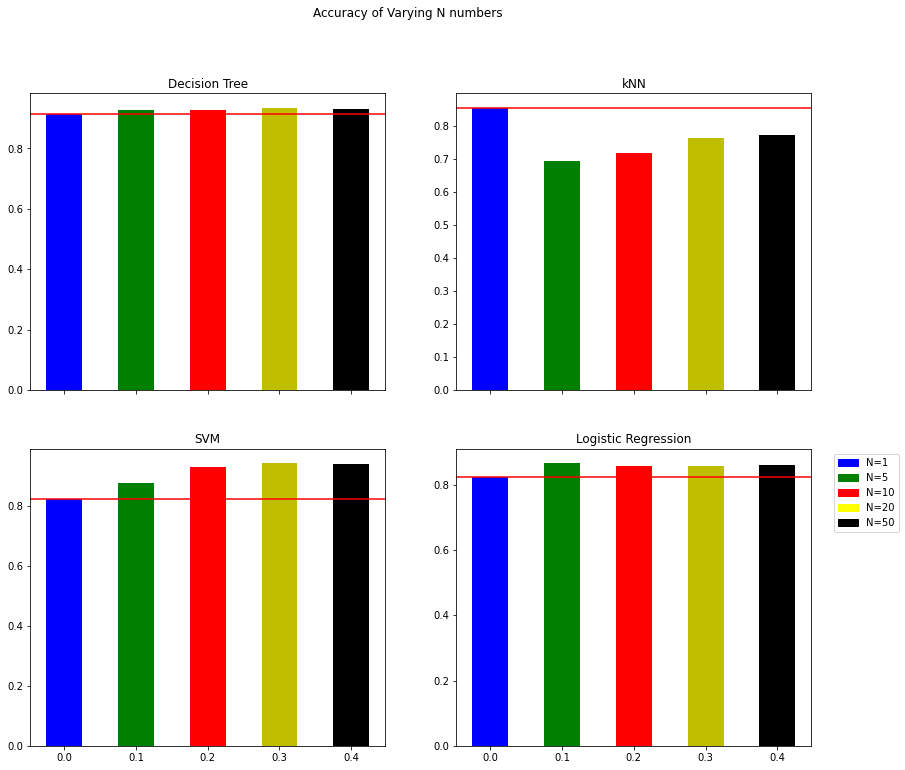

In [42]:
import matplotlib.patches as mpatches

plot_xsection(model_results, 'Accuracy', "Accuracy of Varying N numbers")


In [55]:
reps = 20
clf = svm.SVC(random_state=i)
sv_acc = (cross_val_score(clf, X_valid, y_valid, cv=5).mean())
sv_f1 = (cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())

clf = KNeighborsClassifier()
knn_acc = (cross_val_score(clf, X_valid, y_valid, cv=5).mean())
knn_f1 = (cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())

k_acc_scores, s_acc_scores = [], []
k_f1_scores, s_f1_scores = [], []
for i in range(reps):
    clf = HeterogenousEnsembleClassifier(base_estimator=models['SVM'], hp_range_map=hparams['SVM'], n_estimators=10, random_state=i)
    s_acc_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5).mean())
    s_f1_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())
    clf = HeterogenousEnsembleClassifier(base_estimator=models['kNN'], hp_range_map=hparams['kNN'], n_estimators=10, random_state=i)
    k_acc_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5).mean())
    k_f1_scores.append(cross_val_score(clf, X_valid, y_valid, cv=5, scoring='f1_macro').mean())




Text(0.5, 1.0, 'kNN accuracy')

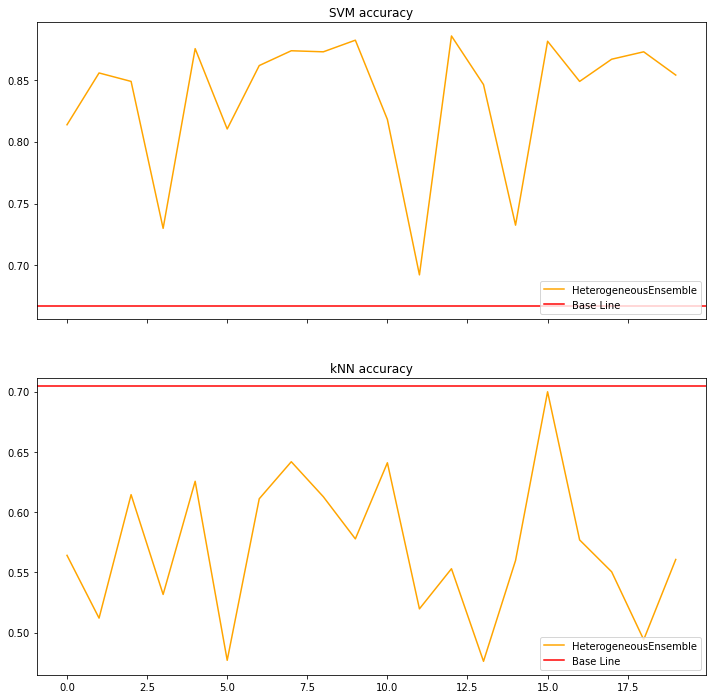

In [56]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)
x = list(range(0,20))
ax1.plot(x, s_acc_scores, label="HeterogeneousEnsemble", color="orange")
ax1.axhline(y=sv_acc, color='red', label='Base Line')
ax1.legend(loc='lower right')
ax1.set_title("SVM accuracy")
ax2.plot(x, k_acc_scores, label="HeterogeneousEnsemble", color="orange")
ax2.axhline(y=knn_acc, color='red', label='Base Line')
ax2.legend(loc='lower right')
ax2.set_title("kNN accuracy")

Text(0.5, 1.0, 'kNN F1')

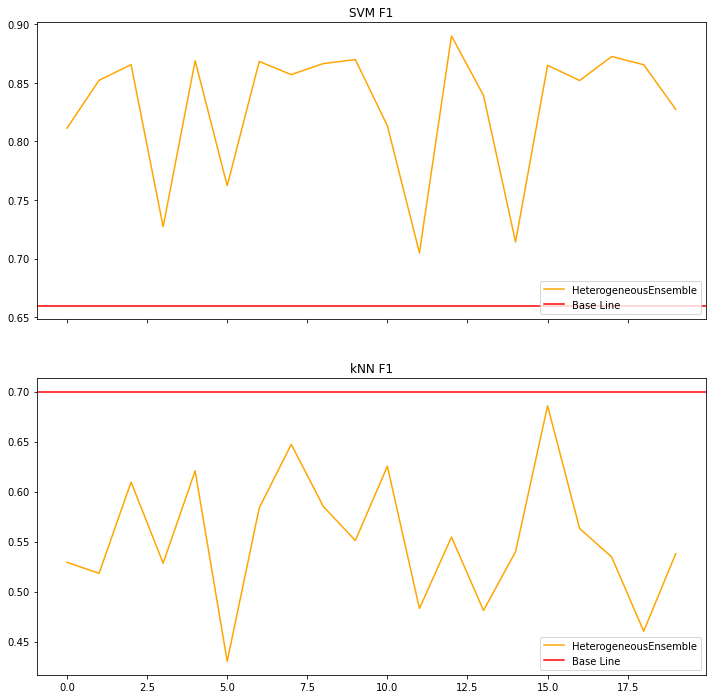

In [58]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,12), sharex=True)
x = list(range(0,20))
ax1.plot(x, s_f1_scores, label="HeterogeneousEnsemble", color="orange")
ax1.axhline(y=sv_f1, color='red', label='Base Line')
ax1.legend(loc='lower right')
ax1.set_title("SVM F1")
ax2.plot(x, k_f1_scores, label="HeterogeneousEnsemble", color="orange")
ax2.axhline(y=knn_f1, color='red', label='Base Line')
ax2.legend(loc='lower right')
ax2.set_title("kNN F1")

### Perform Evaluation Experiment

-- First of all evaluate best classifier on the data with non stacked model

-- Then use the same base classifier with varying different stacked estimators

-- Then compare against 

## Task 4: Reflect on the Performance of the Different Models Evaluated

*Write your refelcection here (max 300 words)*